# NMX Demo
In this example, we will use simulated data from McStas v.3.4.

This is simulated data on a crystal of Rubredoxin, a small protein, using the "standard" conditions for NMX. <br>
| Parameter | Value | Notes |
|-----------|-------|-------|
| `wavelength_range` ($\mathring A$) | 1.8 - 3.55 | The planned range for standard NMX experiments |
| `protein_name` | Rubredoxin | Associated Common protein name |
| `unit_cell` | $a$ = 33.9 $b$ = 34.9 $c$ = 43.5 <br>  $\alpha$ = $\beta$ = $\gamma$ = 90 | Unit cell of rubredoxin |
| `space_group` | $P2_{1}2_{1}2_{1}$ | Space group of rubredoxin

## Build Pipeline (Collect Parameters and Providers)
Import the providers from ``load_mcstas_nexus`` to use the ``McStas`` simulation data workflow. <br>
``MaximumProbability`` can be manually provided to derive more realistic number of events. <br>
It is because ``weights`` are given as probability, not number of events in a McStas file. <br>

In [31]:
from pathlib import Path

from ess.nmx.mcstas import McStasWorkflow
from ess.nmx.data import small_mcstas_3_sample

from ess.nmx.types import *
from ess.nmx.reduction import NMXData, NMXReducedData, merge_panels
from ess.nmx.nexus import export_as_nexus

In [32]:
datafile = "nmx_by_scipp_2E12.h5"

In [33]:
from nmx_workflow.config import POOCH_DATA_DIR
from nmx_workflow.dataset import download_datafiles
download_datafiles([datafile])

Fetching: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


In [34]:
wf = McStasWorkflow()
# Replace with the path to your own file
wf[FilePath] = POOCH_DATA_DIR / datafile
wf[MaximumProbability] = 10000
wf[TimeBinSteps] = 50

In [35]:
wf

We want to reduce all three panels, so we map the relevant part of the workflow over a list of the three panels:

In [36]:
# DetectorIndex selects what detector panels to include in the run
# in this case we select all three panels.
wf[NMXReducedData] = (
    wf[NMXReducedData]
    .map({DetectorIndex: sc.arange('panel', 3, unit=None)})
    .reduce(index="panel", func=merge_panels)
)

## Build Workflow

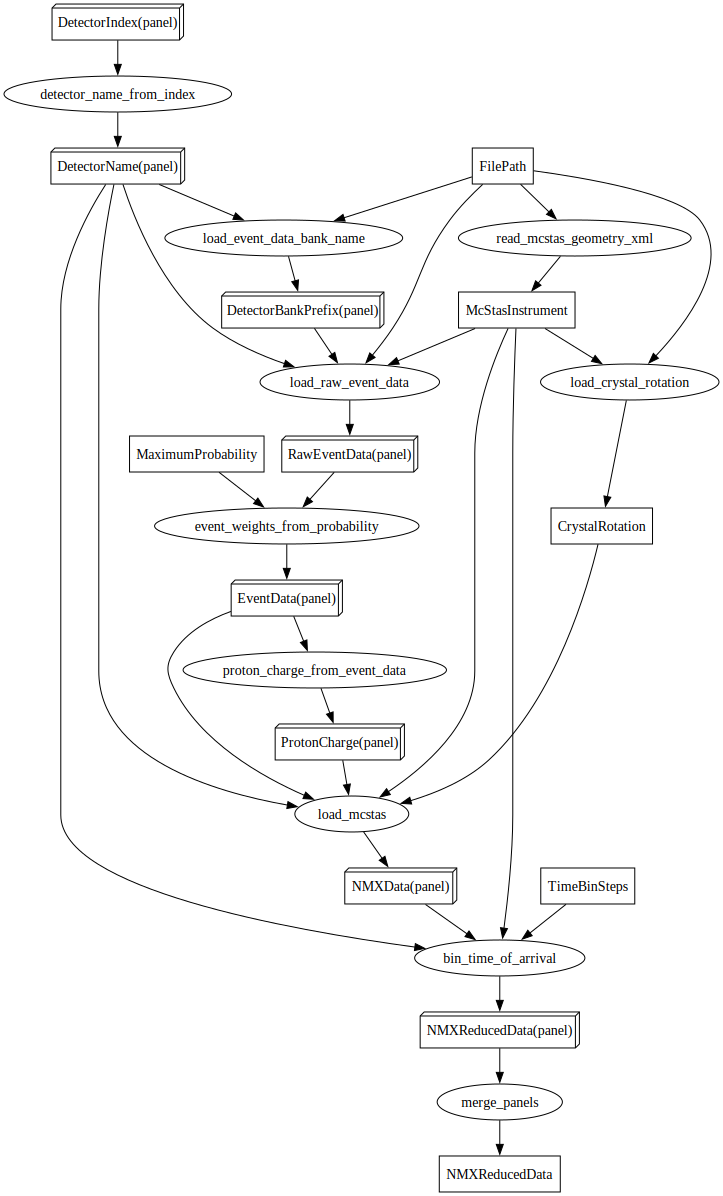

In [37]:
wf.visualize(NMXReducedData, graph_attr={"rankdir": "TD"}, compact=True)

## Compute Desired Types

In [38]:
from cyclebane.graph import NodeName, IndexValues

# Event data grouped by pixel id for each of the selected detectors
targets = [NodeName(NMXData, IndexValues(("panel",), (i,))) for i in range(3)]
dg = merge_panels(*wf.compute(targets).values())
dg

DataGroup(sizes={'panel': 3, 'id': 1638400}, keys=[
    weights: DataArray({'panel': 3, 'id': 1638400}),
    proton_charge: Variable({'panel': 3}),
    crystal_rotation: Variable({}),
    fast_axis: Variable({'panel': 3}),
    slow_axis: Variable({'panel': 3}),
    origin_position: Variable({'panel': 3}),
    sample_position: Variable({}),
    source_position: Variable({}),
    sample_name: Variable({}),
    position: Variable({'panel': 3, 'id': 1638400}),
])

In [39]:
# Data from all selected detectors binned by panel, pixel and timeslice
binned_dg = wf.compute(NMXReducedData)
binned_dg

DataGroup(sizes={'panel': 3, 'id': 1638400, 't': 50}, keys=[
    counts: DataArray({'panel': 3, 'id': 1638400, 't': 50}),
    proton_charge: Variable({'panel': 3}),
    crystal_rotation: Variable({}),
    fast_axis: Variable({'panel': 3}),
    slow_axis: Variable({'panel': 3}),
    origin_position: Variable({'panel': 3}),
    sample_position: Variable({}),
    source_position: Variable({}),
    sample_name: Variable({}),
    position: Variable({'panel': 3, 'id': 1638400}),
])

## Export Results

``NMXReducedData`` object has a method to export the data into nexus or h5 file.

You can save the result as ``test.nxs``, for example:


In [44]:
from nmx_workflow.config import PROCESSED_DATA_DIR

nexus_file = PROCESSED_DATA_DIR / "scipp_export.nxs"
export_as_nexus(binned_dg, nexus_file)

## Instrument View

Pixel positions are not used for later steps,
but it is included in the coordinates for instrument view.

All pixel positions are relative to the sample position,
therefore the sample is at (0, 0, 0).

**It might be very slow or not work in the ``VS Code`` jupyter notebook editor.**

In [45]:
import scippneutron as scn

da = dg["weights"]
da.coords["position"] = dg["position"]
# Plot one out of 100 pixels to reduce size of docs output
view = scn.instrument_view(da["id", ::100].hist(), pixel_size=0.0075)
view

Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(…

This is a quick workaround for current DIALS install, will be fixed later.

In [46]:
import h5py

with h5py.File(nexus_file,'r+') as fp:
    det_data = fp['NMX_data']['NXinstrument']['detector_1']
    fp['NMX_data']['detector_1'] =  det_data
    del fp['NMX_data']['NXinstrument']['detector_1']


## Data Reduction with DIALS

DIALS will be used for spotfinding, indexing, integration.

In [47]:
from libtbx.phil import parse

from dials.command_line import dials_import
from dials.command_line import find_spots
from dials.command_line import index



In [48]:
import_phil = dials_import.phil_scope
format_phil = parse(f"""
output {{
    experiments = {PROCESSED_DATA_DIR}/imported.expt
    log = '{PROCESSED_DATA_DIR}/dials.import.log'
}}
""")
working_phil = import_phil.fetch(
    sources = [format_phil])

In [49]:
dials_import.run(args=[str(nexus_file)], phil=working_phil)

DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

input {
  experiments = <image files>
}

input {
  experiments = <image files>
}

input {
  experiments = <image files>
}

input {
  experiments = <image files>
}

input {
  experiments 

In [50]:
from libtbx.phil import parse

findSpots = parse(f"""
output {{
    reflections = '{PROCESSED_DATA_DIR}/strong.refl'
    log = '{PROCESSED_DATA_DIR}/dials.find_spots.log'
}}
spotfinder {{
    threshold {{
    algorithm = radial_profile
       dispersion {{
         gain = 0.01
         kernel_size = 50 50
         sigma_background = 1
         sigma_strong = 2
         min_local = 1
            }}
         
    }}
    filter {{
       min_spot_size = 80
       max_spot_size = 9000
       max_separation = 20
    }}
}}
""")

working_phil = find_spots.working_phil

findSpots_phil = working_phil.fetch(
    sources=[findSpots])

In [51]:
display(find_spots.run(args=[str(PROCESSED_DATA_DIR/'imported.expt'),str(PROCESSED_DATA_DIR/'find_spots.phil')],phil=find_spots.working_phil))

DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

output {
  reflections = "/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/strong.refl"
  log = "/User

None

In [52]:
display(index.run(args=[str(PROCESSED_DATA_DIR/'imported.expt'),str(PROCESSED_DATA_DIR/'strong.refl'), 'unit_cell=33.41,34.75,43.65,90,90,90','space_group=P212121']))

DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
DIALS 3.dev.1168-g0da4e1d1e
The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

The following parameters have been modified:

indexing {
  known_symmetry {
    spac

SystemExit: No reflections available for refinement

/Users/aaronfinke/dialsforneutrons/conda_base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

/Users/aaronfinke/dialsforneutrons/conda_base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

/Users/aaronfinke/dialsforneutrons/conda_base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

/Users/aaronfinke/dialsforneutrons/conda_base/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)

/Users/aaronfinke/dialsforneutrons/conda_base/lib/python3.11/site-packag

In [55]:
from dials.command_line import image_viewer
image_viewer.run(args=['imported.expt'])

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for dials::algorithms::profile_model::gaussian_rs::BBoxMultiCalculator already registered; second conversion method ignored.

<frozen importl

2024-10-16 12:34:08.910 python[7244:9494944] Warning: The declared constraints for <NSToolbarItemViewer: 0x319eca5c0 '105553141183232'> were previously invalidated only because a declared constraint was snipped or manually deactivated. This indicates missing invalidation for a view's changing state that affects its declared constraints. To debug, set a breakpoint on `_NSViewRemovedDeclaredConstraintBreakpoint`
2024-10-16 12:34:08.910 python[7244:9494944] Warning: The declared constraints for <NSToolbarItemViewer: 0x319ecbd70 '105553141177600'> were previously invalidated only because a declared constraint was snipped or manually deactivated. This indicates missing invalidation for a view's changing state that affects its declared constraints. To debug, set a breakpoint on `_NSViewRemovedDeclaredConstraintBreakpoint`
2024-10-16 12:34:08.910 python[7244:9494944] Warning: The declared constraints for <NSToolbarItemViewer: 0x319ed0480 '105553141272576'> were previously invalidated only bec